**Notebook 3 – Hyperparameter Fitting**

_This notebook introduces how to search for optimal learning parameters._
jens.schwarzbach@ukr.de

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jvschw/ml4ni/blob/master/ML4NI/3_hyperparameter_fitting.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Hyperparameter Fitting

Neural Network Models have many free parameters, most importantly the weights between different units. But machine leaning also knows hyperparameters, which are parameters of a learning algorithm (not of the model). 

<img src="images/hyper/hyper.png">

When training a deep neural network on a given problem there is no known way to know the optimal hyperparameters ahead of time. Instead, we need to search for them.

The general strategy looks like this.

In [ ]:
from sklearn.model_selection import GridSearchCV

n_neurons = [300]; #classically not considered a hyper parameter
learn_rate = [0.001, 0.01, 0.1, 0.2]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8]
param_grid = dict(learn_rate=learn_rate, momentum=momentum, n_neurons=n_neurons)


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X, Y)


Below, find the full pipeline for our foot-finger-tongue mapper.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

import tensorflow as tf
from tensorflow import keras

# Use scikit-learn to grid search the learning rate and momentum
import numpy
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

# Function to create model, required for KerasClassifier
def create_model(n_hidden=2, n_neurons=30, learn_rate=3e-3, momentum=0, nFeatures=100):
    print(n_hidden, n_neurons, learn_rate)
    model = keras.models.Sequential()   
    model.add(keras.layers.Flatten(input_shape=(nFeatures,)))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(6, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

import nibabel as nib #if this throws an error consider 'python3 -m pip install -U nibabel'

def load_data():
    #load a structural scan and use brain voxels as mask for statistical parameter maps (SPMs)
    
    #Load structural scan
    #ref_anat = '/content/ml4ni/ML4NI/parameterMaps/FFT001_T1_lores.nii.gz'
    ref_anat = './parameterMaps/FFT001_T1_lores.nii.gz'
    imgT1 = nib.load(ref_anat)
    
    #extract features (voxel intensities of the structural scan)
    XT1 = imgT1.get_fdata() 
    
    #create mask from structural scan where voxels have a value higher than 0
    msk2 = XT1>0 
    nMaskedVoxels = msk2.sum()
    
    #Load SPMs (stacked 3D maps)
    #fNameSPM = '/content/ml4ni/ML4NI/parameterMaps/FFT001.nii.gz'
    fNameSPM = './parameterMaps/FFT001.nii.gz'
    imgSPM = nib.load(fNameSPM)
    
    #extract features (t-values)
    XSPM = imgSPM.get_fdata() 
    print("Data dimensionality is:", XSPM.shape)
    nMaps=XSPM.shape[3]
    
    #create flattened and masked feature matrix[nMaps,nFeaturesInsideBrain]
    XflatMasked = np.empty([nMaps, nMaskedVoxels])
    for iMap in range(nMaps):
        #extract one flattened map
        tmpFlat = XSPM[:, :, :,iMap].flatten()
        #mask flattened map and assign to feature matrix
        XflatMasked[iMap,:]=tmpFlat[XT1.flatten()>0] 
    print("Dimensionality of flattened and masked feature matrix: ", XflatMasked.shape)    
    
    #SPLIT EXECUTION DATA (MAPS 1:60) FROM IMAGERY DATA (MAPS 61-66)
    #first 60 maps 10 runs with 6 conditions each
    dataLearn=XflatMasked[:60] 
    #last 6 maps (run 11 with 6 conditions). This is not really a holdout map, since this
    #is imagery data, whereas the first 60 maps are execution data
    dataHoldout=XflatMasked[60:] 
    
    #CREATE LABELS
    #labels
    #chunks = np.empty([66, 1], dtype=int) #run number [not yet used]
    labels = np.empty([nMaps, 1], dtype=int) #condition number
    counter=0
    for iRun in range(11):
        for iCond in range(6):
            #chunks[counter] = iRun #11 runs (0-10)
            labels[counter] = iCond #6 conditions (0-5)
            counter+=1
    labelsLearn=labels[:60] #first 60 (0:59) execution
    labelsHoldout=labels[60:] #last 6 (60:65) imagery
    
    class_names=["FingL", "FingR", "FootL", "FootR", "TongueL", "TongueR"]  
    
    return dataLearn, labelsLearn, dataHoldout, labelsHoldout, class_names, msk2;



# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
#----------------------------------------------------------
#load data
#----------------------------------------------------------
dataLearn, labelsLearn, dataHoldout, labelsHoldout, class_names, msk2 = load_data()
X = dataLearn
Y = labelsLearn
nFeatures=dataLearn.shape[1]

# create model
model = KerasClassifier(build_fn=create_model, nFeatures=nFeatures, epochs=20, batch_size=6, verbose=2)

#----------------------------------------------------------
# define the grid search parameters
#----------------------------------------------------------
n_neurons = [10, 50, 100, 300];
learn_rate = [0.001, 0.01, 0.1, 0.2]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8]
param_grid = dict(learn_rate=learn_rate, momentum=momentum, n_neurons=n_neurons)


#----------------------------------------------------------
# S E A R C H
#----------------------------------------------------------
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X, Y)


#----------------------------------------------------------
# summarize results
#----------------------------------------------------------
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Data dimensionality is: (64, 100, 67, 66)
Dimensionality of flattened and masked feature matrix:  (66, 104578)
2 300 0.001
Train on 60 samples
Epoch 1/20
60/60 - 1s - loss: 3.0989 - accuracy: 0.4500
Epoch 2/20
60/60 - 1s - loss: 0.5471 - accuracy: 0.9000
Epoch 3/20
60/60 - 1s - loss: 0.1043 - accuracy: 0.9833
Epoch 4/20
60/60 - 1s - loss: 0.0284 - accuracy: 1.0000
Epoch 5/20
60/60 - 1s - loss: 0.0212 - accuracy: 1.0000
Epoch 6/20
60/60 - 1s - loss: 0.0175 - accuracy: 1.0000
Epoch 7/20
60/60 - 1s - loss: 0.0143 - accuracy: 1.0000
Epoch 8/20
60/60 - 1s - loss: 0.0124 - accuracy: 1.0000
Epoch 9/20
60/60 - 1s - loss: 0.0110 - accuracy: 1.0000
Epoch 10/20
60/60 - 1s - loss: 0.0099 - accuracy: 1.0000
Epoch 11/20
60/60 - 1s - loss: 0.0089 - accuracy: 1.0000
Epoch 12/20
60/60 - 1s - loss: 0.0082 - accuracy: 1.0000
Epoch 13/20
60/60 - 1s - loss: 0.0075 - accuracy: 1.0000
Epoch 14/20
60/60 - 1s - loss: 0.0070 - accuracy: 1.0000
Epoch 15/20
60/60 - 1s - loss: 0.0065 - accuracy: 1.0000
Epoch 16/20

In [33]:
grid_result.best_params_

{'learn_rate': 0.001, 'momentum': 0.0, 'n_neurons': 300}

In [41]:
#TRAIN MODEL WITH BEST HYPERPARAMETERS ON ALL DATA
best_learn_rate = grid_result.best_params_.get('learn_rate')
best_momentum = grid_result.best_params_.get('momentum')
best_n_neurons =grid_result.best_params_.get('n_neurons')

model=create_model(n_hidden=2, n_neurons=best_n_neurons, learn_rate=best_learn_rate,
                   momentum=best_momentum, nFeatures=nFeatures)

historyBest = model.fit(X, Y, epochs=20, batch_size=6)

#save model
model.save("new_FFT_execution_final_optimized.h5")


2 300 0.001
Train on 60 samples
Epoch 1/20
60/60 [==============================] - 1s 21ms/sample - loss: 2.0286 - accuracy: 0.4500
Epoch 2/20
60/60 [==============================] - 1s 16ms/sample - loss: 0.6012 - accuracy: 0.9167
Epoch 3/20
60/60 [==============================] - 1s 17ms/sample - loss: 0.1527 - accuracy: 0.9333
Epoch 4/20
60/60 [==============================] - 1s 17ms/sample - loss: 0.0236 - accuracy: 1.0000
Epoch 5/20
60/60 [==============================] - 1s 17ms/sample - loss: 0.0129 - accuracy: 1.0000
Epoch 6/20
60/60 [==============================] - 1s 17ms/sample - loss: 0.0106 - accuracy: 1.0000
Epoch 7/20
60/60 [==============================] - 1s 17ms/sample - loss: 0.0091 - accuracy: 1.0000
Epoch 8/20
60/60 [==============================] - 1s 17ms/sample - loss: 0.0079 - accuracy: 1.0000
Epoch 9/20
60/60 [==============================] - 1s 17ms/sample - loss: 0.0071 - accuracy: 1.0000
Epoch 10/20
60/60 [==============================] - 1s 17m

Test on imagery values

In [42]:
model.evaluate(dataHoldout, labelsHoldout)

6/6 [==============================] - 0s 21ms/sample - loss: 0.8307 - accuracy: 0.8333


[0.830707311630249, 0.8333333]

Analyze behavior of the best model.

In [45]:
import matplotlib.pyplot as plt
def annotated_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots()
    im = ax.imshow(cm)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
    ax.set_ylabel('predicted')
    ax.set_xlabel('exp. condition')


    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")



labels:  [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]
predictions:  [0 1 2 3 0 5]


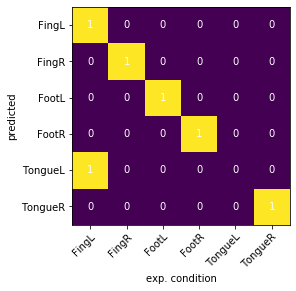

In [46]:
from sklearn.metrics import confusion_matrix
y_predHoldout = model.predict_classes(dataHoldout)
print("labels: ", labelsHoldout)
print("predictions: ", y_predHoldout)

cm = confusion_matrix(labelsHoldout, y_predHoldout)
annotated_confusion_matrix(cm, class_names)